# Expectation Maximization

## Overview

Automatic image processing is a key component to many AI systems, including facial recognition and video compression, instance segmentation of images and point cloud data. One basic method for processing is segmentation, by which we divide an image into a fixed number of components in order to simplify its representation. For example, we can train a mixture of Gaussians to represent an image, and segment it according to the simplified representation as shown in the images below.

![alt text](images/k6_Starry.png)

Or we could perform a clustering of point cloud in order to separate different objects, backgrounds etc, as shown in the image below

![alt text](images/pcd_clustered.gif)

In this project we will perform image compression and point cloud segmentation and implement Gaussian mixture models and iteratively improve their performance. First we perform segmentation on the "Starry" (`Starry.png`) and at the end run the algorithm on 3D point cloud data.

To begin, we will implement several methods of image segmentation, with increasing complexity:

1. Implement k-means clustering to segment a color image.

2. Familiarize yourself with the algorithm by running it on simple dataset.

3. Build a Gaussian mixture model to be trained with expectation-maximization.

4. Experiment with varying the details of the Gaussian mixture model’s implementation.

5. Implement and test a new metric called the Bayesian information criterion, which guarantees a more robust image segmentation.

<br>

- - -

## K-means Clustering

One easy method for image segmentation is to simply cluster all similar data points together and then replace their values with the mean value. Thus, we'll warm up using k-means clustering. This will also provide a baseline to compare with the segmentation.

In [4]:
%load_ext autoreload
%autoreload 2
from ipywidgets import *
import mixture_tests as tests
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from scipy.stats import norm
import os
import numpy as np
from tools import *

In [5]:
import numpy as np
from tools import *

In [6]:
def get_initial_means(array, k):

    initial_means = array[np.random.choice(array.shape[0], k, replace=False), :]
    
    return initial_means


In [7]:
def k_means_step(X, k, means):

    distances = np.zeros([len(X), k])
    new_means = []
    for i in range(k):
        distances[:, i] = np.sum((X - means[i])**2, axis=1)

    clusters = np.argmin(distances, axis=1)
    for i in range(k):
        #clusters = np.argmin(distances, axis=1)
        if not (np.where(clusters == i)[0].size == 0):
            #print(means[i])
            means[i] = np.sum(X[np.where(clusters == i)[0]], axis=0)
            new_means.append(means[i] / np.where(clusters == i)[0].size)
    
    new_means = np.array(new_means)
    #clusters = np.argmin(distances, axis=1)

    return (new_means, clusters)


#### K-means - Visualizing the results

Now that we are done with the K-means step implementation lets try to visualize what's happening if repeating these steps multiple times.

In [8]:
# This cell contains a code for loading a dataset from the `data` folder
# Each of these datasets contains synthtic (generated) data
# You can simply run this cell for now and come back to it later if you want to make changes
# Make sure you implemented everything in cells above and passed the unittests
def K_means_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("The dataset is of a size:", X.shape)

    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the clusters,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))

    # Feel free to edit the termination condition for the K-means algorithm
    # Currently is just runs for n_iterations, before terminating
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    # keeping track of how clusters and means changed, for visualization purposes
    means_history = [means]
    clusters_history = [clusters] 
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)

    return X, y, means_history, clusters_history


In [9]:
dataset_index = 2 # for different dataset change it to number from [0,4]
K = 5 # Number of clusters - play with this number

X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clusters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(1,len(clusters_history)-1,1))

The dataset is of a size: (1000, 2)


interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

### Image segmentation
2D data clustering is all cool and all but now it's time to use K-means for the image compression! 



We will separate the provided RGB values into k clusters using the k-means algorithm, then return an updated version of the image with the original values replaced with the corresponding cluster center values.

Since clustering is best used on multidimensional data, we will be using the color image `Starry.png`.

The function should return an updated version of the image with the original values replaced with the corresponding cluster values.

In [10]:
def k_means_segment(image_values, k=3, initial_means=None):

    image_values_reshape = image_values.reshape(-1, image_values.shape[-1])

    if initial_means is None:
        initial_means = get_initial_means(image_values_reshape, k)

    old_means, old_clusters = k_means_step(image_values_reshape, k, initial_means)

    while True:
        means, clusters = k_means_step(image_values_reshape, k, old_means)
        image_segment = np.copy(image_values_reshape)
        if np.sum(clusters - old_clusters) == 0:
            for i in range(k):
                image_segment[np.where(clusters == i)] = means[i]
            image_segment = image_segment.reshape([image_values.shape[0], image_values.shape[1],\
                                         image_values.shape[-1]])
            return image_segment
        old_means, old_clusters = means, clusters
    

### Visulizing K-means segmentation results

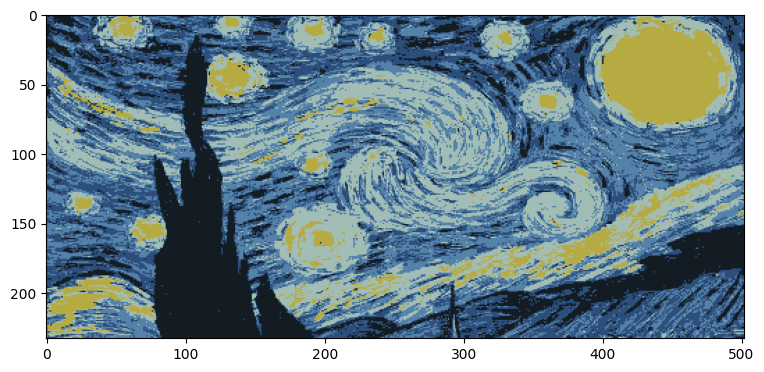

In [11]:
k=5 # number of clusters - feel free to play with it

image_values = image_to_matrix('images/Starry.png')
# Play with the K value below to see the effect number of clusters have
new_image = k_means_segment(image_values, k=k)

plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

## Implementing a Multivariate Gaussian Mixture Model

Next, we will step beyond clustering and implement a complete Gaussian mixture model. It's time to complete the implementation of the functions below what will later assemble into a Multivariate Gaussian Expectation Maximization algorithm:

1. Calculate the probability of a given data point (e.g. rgb value of a pixel) of belonging to a specific Gaussian component. (7 points)

2. Use expectation-maximization (EM) to train the model to represent the image as a mixture of Gaussians. (20 points)


Our implementation is following the above functions order - 
1. initialize_parameters
2. prob
3. E_step
4. M_step
5. likelihood 
6. train_model
7. cluster
8. segment
9. best_segment

For the synthetic data test which we provide to check if the training is working, the set is too small and it won't make a difference. But with the actual image that we use ahead, for-loops won't do good. Vectorized code would take under 30 seconds to converge which would typically involve about 15-20 iterations with the convergence function we have here. Inefficient code that uses loops or iterates over each pixel value sequentially, will take hours to run, and we don't want to do that.

In [12]:
def compute_sigma(X, MU):

    k = MU.shape[0]
    SIGMA = np.zeros((k, X.shape[1], X.shape[1]))
    for i in range(k):
        SIGMA[i] = np.dot((X - MU[i]).T,(X - MU[i])) / X.shape[0]
    return SIGMA


Same as in K-means you will be working with the data of size (m x n). 

In [13]:
def initialize_parameters(X, k):
    m,n = X.shape
    MU = X[np.random.choice(m, k, replace=False)]

    #SIGMA = compute_sigma(X,MU)
    SIGMA = np.zeros((k, n, n))
    for i in range(k):
        SIGMA[i] = np.dot((X - MU[i]).T,(X - MU[i])) / X.shape[0]

    PI = np.ones([k]) / k

    return (MU, SIGMA, PI)

Prob function below gives a probability density estimate which we loosely (and definitely not accurately) call probability. As you can imagine the density function can take any value and can certainly be greater than 1. The prob function isn't really calculating probability but probability density.

In [14]:
def prob(x, mu, sigma):
    x = x.reshape(-1,mu.shape[0])
    normalizer = 1 / ((2 * np.pi)**(mu.shape[0] / 2) * np.linalg.det(sigma)**(1 / 2))
    x_dist = np.dot((x - mu),np.linalg.inv(sigma))
    x_exponent = (-1 / 2) * (x_dist * (x - mu)).sum(-1)
    normal_distribution = np.exp(x_exponent)
    probability = normalizer * normal_distribution
    if len(x) == 1:
        return probability[0] 
    else:
        return np.array(probability)


In [15]:
def E_step(X,MU,SIGMA,PI,k):

    m, n = X.shape

    res_numerator = np.zeros([k, m])

    for i in range(k):
        res_numerator[i] = PI[i] * prob(X, MU[i], SIGMA[i])
    responsibility = res_numerator / np.sum(res_numerator, axis=0)

    return responsibility

In [16]:
def M_step(X, r, k):
    m, n = X.shape
    new_MU = np.zeros((k, n))
    new_SIGMA = np.zeros((k, n, n))
    new_PI = np.zeros((k, 1))
    for i in range(k):
        r_reshape = r[i].reshape(-1,1)
        new_MU[i] = np.sum(X * r_reshape, 0) / sum(r_reshape)
        new_SIGMA[i] = (np.dot(r[i] * (X - new_MU[i]).T , (X - new_MU[i]))) / sum(r_reshape)
        new_PI[i] = (sum(r_reshape) / m)
    new_PI = new_PI.T[0]
    return (new_MU, new_SIGMA, new_PI)

In [17]:
def likelihood(X, PI, MU, SIGMA, k):
    m, n = X.shape
    log_likelihood = np.zeros((k,m))
    for i in range(k):
        log_likelihood[i] = PI[i] * prob(X, MU[i], SIGMA[i])
    log_likelihood = np.sum(log_likelihood,axis = 0)
    log_likelihood = np.sum(np.log(log_likelihood))
    return log_likelihood

In [18]:
def train_model(X, k, convergence_function, initial_values = None):
    if initial_values is None:
        MU, SIGMA, PI = initialize_parameters(X, k)
    else:
        MU, SIGMA, PI = initial_values
        
    
    log_likelihood = likelihood(X, PI, MU, SIGMA, k)
    conv_ctr = 0
    while True:
        responsibility = E_step(X, MU, SIGMA, PI,k)
        new_MU, new_SIGMA, new_PI = M_step(X, responsibility, k)
        new_log_likelihood = likelihood(X, PI, MU, SIGMA, k)
        conv_ctr, converged = convergence_function(log_likelihood, new_log_likelihood, conv_ctr)
        if converged:
            return (new_MU, new_SIGMA, new_PI, responsibility)
        else:
            log_likelihood = new_log_likelihood
            MU, SIGMA, PI = new_MU, new_SIGMA, new_PI


In [19]:
def cluster(r):

    clusters = np.argmax(r,axis=0)

    return clusters


In [20]:
def segment(X, MU, k, r):
    
    new_X = MU[cluster(r)]
    return new_X


In [21]:
def best_segment(X,k,iters):

    likelihood_val = 0
    current_likelihood = 0
    MU, SIGMA, PI, responsibility = train_model(X, k, default_convergence)
    segment_val = segment(X,MU,k,responsibility)
    for i in range(iters):
        current_likelihood = likelihood(X, PI, MU, SIGMA, k)
        if current_likelihood > likelihood_val:
            likelihood_val = current_likelihood
            segment_val = segment(X,MU,k,responsibility)
    return (likelihood_val,segment_val)


#### GMM - Visualizing the results

Now that you are done with the EM implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next 2 cells, but you are highly encouraged to play with parameters and datasets, to get a visual sense of what is happening at every step.**


Feel free to explore and improve the function below, it will be used for visualizing GMM progress
but it's not required and WON'T effect your grade.

In [22]:
def GMM_2D_dataset(dataset_index, K):
    
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("There are %d datapoints in the current dataset, each of a size %d" % X.shape)
    print("""\nNote that that the Gaussian Ellipses and Normal Curves may not share the
same color as the points they represent (within the same chart).
In fact, the Gaussian Ellipses and Normal Curves represent the clusters
in the top left chart (and thus share colors with those points).""")
    
    # Load the labels
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    MU, SIGMA, PI = initialize_parameters(X, K)
    
    clusters_history = []
    statistics_history = []
    for _ in range(200):
        r = E_step(X,MU,SIGMA,PI,K)
        new_MU, new_SIGMA, new_PI = M_step(X, r, K)
        PI, MU, SIGMA = new_PI, new_MU, new_SIGMA
        clusters = cluster(r)
        clusters_history.append(clusters)
        statistics_history.append((PI, MU, SIGMA))

    return X, y, clusters_history, statistics_history

In [23]:
dataset_index = 3
K = 3

X, y, clusters_history, statistics_history = GMM_2D_dataset(dataset_index, K)

def setup_subplot(plt, i, title, plot_number):
    ax = plt.subplot(2, 2, plot_number)
    ax.set_title(title)
    ax.patch.set_facecolor('gray')
    ax.patch.set_alpha(0.1)
    return ax

def plot_gaussian_ellipse(k, mean, covar, ax2, colors):
    v,w = np.linalg.eig(covar)
        
    angle = np.arctan(w[1,0] / w[0,0])
    angle = 180 * angle / np.pi
    
    color = colors[k % len(colors)]
    for i in range(3,8):
        plot_v = i * np.sqrt(v)
        ellipse = pat.Ellipse(mean, plot_v[0], plot_v[1], angle, fill = True, alpha = 0.10, lw = 1.0, ls = 'dashdot', ec = 'black', fc = color, zorder = 0)
        ax2.add_artist(ellipse)

def plot_gaussian(X, mean, var, X_min, X_max, ax):
    samples = np.linspace(X_min, X_max, 100)
    ax.plot(samples, norm.pdf(samples, mean, var))
    

def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    cluster_means = statistics_history[i][1]
    cluster_covar = statistics_history[i][2]
    
    plt.figure(None, figsize=(15,12)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorithm training progress')
    
    ax1 = setup_subplot(plt, i, 'GMM clusters - step %d' % i, 1)
    ax2 = setup_subplot(plt, i, 'Ground truth clusters', 2)
    ax3 = setup_subplot(plt, i, 'GMM Gausians X1 - step %d' % i, 3)
    ax4 = setup_subplot(plt, i, 'GMM Gausians X2 - step %d' % i, 4)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for k in range(K):
        ax1.plot(X[clusters==k, 0], X[clusters==k, 1], '.')
        
        mean = cluster_means[k]
        covar = cluster_covar[k]
        
        plot_gaussian_ellipse(k, mean, covar, ax2, colors)
        plot_gaussian(X[clusters==k, 0], mean[0], covar[0,0], np.min(X[:, 0]), np.max(X[:, 0]), ax3)
        plot_gaussian(X[clusters==k, 1], mean[1], covar[1,1], np.min(X[:, 1]), np.max(X[:, 1]), ax4)
    
    ax3.set_prop_cycle(None)
    ax4.set_prop_cycle(None)
    
    for i in np.unique(y):
        ax2.plot(X[y==i,0], X[y==i,1],'.', zorder=10)
        ax3.plot(X[y==i,0], np.zeros(X[y==i,0].shape[0]), '.', zorder = 10)
        ax4.plot(X[y==i,1], np.zeros(X[y==i,1].shape[0]), '.', zorder = 10)
    
    plt.show()

interactive(get_cluster, {'manual': True}, i=(0,len(clusters_history)-1,1))


There are 1000 datapoints in the current dataset, each of a size 2

Note that that the Gaussian Ellipses and Normal Curves may not share the
same color as the points they represent (within the same chart).
In fact, the Gaussian Ellipses and Normal Curves represent the clusters
in the top left chart (and thus share colors with those points).


interactive(children=(IntSlider(value=99, description='i', max=199), Button(description='Run Interact', style=…

### Visualize the image compression results of GMM.

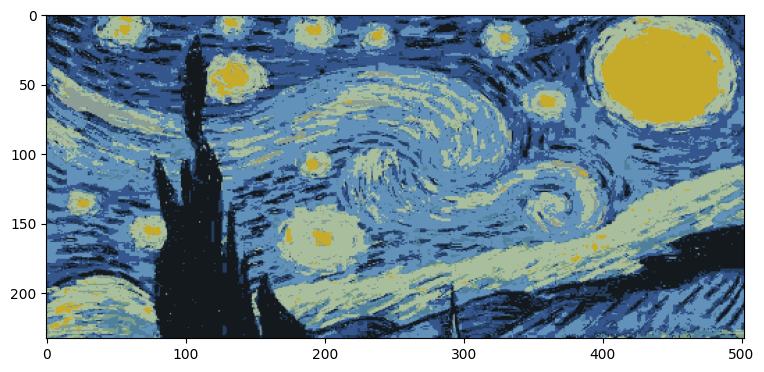

In [24]:
image_file = 'images/Starry.png' # Image path
original_image_matrix = image_to_matrix(image_file)
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension
K = 10 # K

_, best_seg = best_segment(image_matrix, K, iters = 10)
new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size

plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

---

## Model Experimentation

We'll now experiment with a few methods for improving GMM performance.

### Improved Initialization 

To run EM in our baseline Gaussian mixture model, we use random initialization to determine the initial values for our component means. We can do better than this!

Train a GMM to find initial means. This type of initialization differs from simply increasing training time because we "reset" the covariance and mixing coefficient parameters. That is, for training, we recompute covariance parameters based on the means we learned during initialization and again set the mixing coefficients to a uniform distribution. A GMM tends to converge to elongated covariances, so by resetting these parameters we have a higher chance of avoiding local maxima.


In [25]:
def improved_initialization(X,k):

    m, n = X.shape
    MU = X[np.random.choice(m, k, False)]

    i = 0
    while i < 50:
        MU, clusters = k_means_step(X, k, MU)
        i += 1

    SIGMA = np.zeros((k, n, n))
    for i in range(k):
        SIGMA[i] = np.dot((X - MU[i]).T, (X - MU[i])) / m
    PI = np.ones((k)) / k
    return MU, SIGMA, PI


## Convergence Condition

In [26]:
def new_convergence_function(previous_variables, new_variables, conv_ctr,
                             conv_ctr_cap=10):
    flag = [False, False,False]
    for i in range(3):
        if np.all(((new_variables[i] - previous_variables[i]) / previous_variables[i]) < 0.1):
            flag[i] =True

    if flag == [True,True,True]:
        conv_ctr += 1
    else:
        conv_ctr = 0

    return conv_ctr, conv_ctr > conv_ctr_cap

def train_model_improved(X, k, convergence_function, initial_values = None):

    if initial_values is None:
        initial_values = improved_initialization(X, k)
    
    
    MU, SIGMA, PI = initial_values
        
    conv_ctr = 0
    while True:
        responsibility = E_step(X, MU, SIGMA, PI, k)
        pre_MU, pre_SIGMA, pre_PI = MU, SIGMA, PI
        MU, SIGMA, PI = M_step(X, responsibility, k)
        conv_ctr, converged = convergence_function((pre_MU, pre_SIGMA, pre_PI), (MU, SIGMA, PI), conv_ctr)
        if converged:
            return MU, SIGMA, PI, responsibility


## Bayesian Information Criterion

In our previous solutions, our only criterion for choosing a model was whether it maximizes the posterior likelihood regardless of how many parameters this requires. As a result, the "best" model may simply be the model with the most parameters, which would be overfit to the training data.

To avoid overfitting, we can use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (a.k.a. BIC) which penalizes models based on the number of parameters they use. In the case of the Gaussian mixture model, this is equal to the number of components times the number of variables per component (mean, variance and mixing coefficient).


### Implement BIC


Calculate the BIC of a trained Gaussian Mixture Model (based on the given parameters).

Note: In the formula of BIC,  `k`  is the number of parameters estimated by the model. This is different from 'k', the number of clusters.

In [27]:
def bayes_info_criterion(X, PI, MU, SIGMA, k):

    m, n = X.shape
    num_params = n + k * n * n
    log_likelihood = likelihood(X, PI, MU, SIGMA, k)
    bayes_info_criterion_val = num_params * np.log(m) - 2 * log_likelihood
    return bayes_info_criterion_val


## Test BIC

Now we will use the BIC and likelihood to determine the optimal number of components in the `image_matrix` parameter. Using `train_model()` or `train_model_improved()`, iterate over the list of provided means (`comp_means`) to train a model that minimizes its BIC and a model that maximizes its likelihood. 

Return:

1) The number of components which result in the minimum BIC

2) The number of components which result in the highest likelihood

`comp_means` is a list, where each element is a k x n matrix of means (where k = # of clusters).

In [28]:
def BIC_likelihood_model_test(image_matrix, comp_means):
    n_comp_min_bic = 0 
    n_comp_max_likelihood = 0
    min_bic = np.inf 
    max_likelihood = 0
    
    for mean in comp_means:
        k = mean.shape[0] 
        MU, SIGMA, PI, responsibility = train_model(image_matrix, k, default_convergence)
        if bayes_info_criterion(image_matrix, PI, MU, SIGMA, k) < min_bic:
            n_comp_min_bic = k
        if likelihood(image_matrix, PI, MU, SIGMA, k) > max_likelihood:
            n_comp_max_likelihood = k
    return (n_comp_min_bic, n_comp_max_likelihood)

---